<a href="https://colab.research.google.com/github/KimRass/Programming/blob/master/Data%20Science/Machine%20Learning/Time%20Series/Quandl%20WIKI%20Stock%20Prices%20%26%20TimeGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

In [1]:
# Data Science/Machine Learning/Time Series/Quandl WIKI Stock Prices & TimeGAN.ipynb
from google.colab import drive
import os
drive.mount("/content/drive")
os.chdir("/content")

import seaborn as sb
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import time
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, LayerNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv1DTranspose, Conv2D, Conv2DTranspose, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D, RepeatVector
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adagrad, Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
# MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras import losses
# MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
from tensorflow.keras.initializers import RandomNormal, glorot_uniform, he_uniform, Constant

plt.style.use("dark_background")

Mounted at /content/drive


In [2]:
os.chdir("/content/drive/MyDrive/TS")
raw_data = pd.read_hdf("Datasets/Quandl WIKI Stock Prices/assets.h5", key="quandl/wiki/prices")

In [3]:
data = raw_data["adj_close"]
data = data.unstack("ticker")
tickers = ["BA", "CAT", "DIS", "GE", "IBM", "KO"]
data = data[tickers]
data = data.dropna()
# data.asfreq("D")

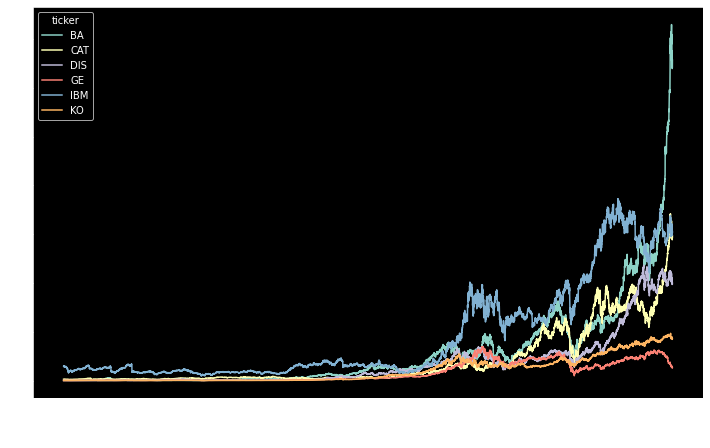

In [4]:
data.plot.line(figsize=(12, 8));

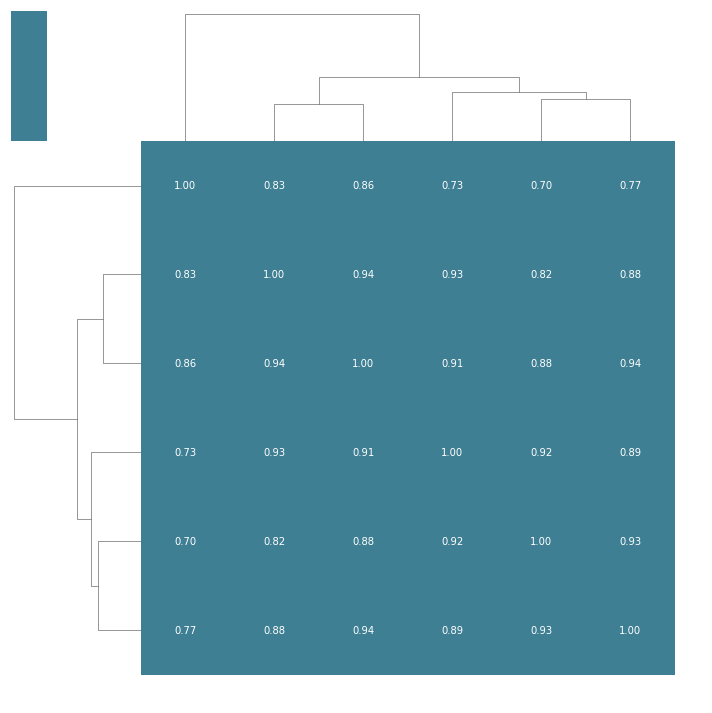

In [5]:
sb.clustermap(data.corr(), annot=True, fmt=".2f", cmap=sb.diverging_palette(h_neg=20, h_pos=220), center=0);

In [6]:
# sc = StandardScaler()
sc = MinMaxScaler()
data_norm = sc.fit_transform(data)

def blocked_cv(data, window_size, h, step=1):
    X = list()
    for i in range(0, len(data) - window_size - h + 1, step):
        X.append(data[i:i + window_size])
    return X

window_size = 24
X = blocked_cv(data_norm, window_size, h=0)

In [7]:
batch_size = 128
dataset_real = tf.data.Dataset.from_tensor_slices(X).shuffle(buffer_size=len(X)).batch(batch_size)
# dataset_real_iter = iter(dataset_real.repeat())

n_features = data_norm.shape[1]
def gen():
    # while True:
    yield np.random.uniform(low=0, high=1, size=(window_size, n_features))
# dataset_rand = iter(tf.data.Dataset.from_generator(gen, output_types=tf.float32).batch(batch_size).repeat())
dataset_rand = tf.data.Dataset.from_generator(gen, output_types=tf.float32).batch(batch_size)

# Modeling

In [8]:
# writer = tf.summary.create_file_writer(log_dir.as_posix())

# Real data
X = Input(shape=(window_size, n_features), name="RealData")
# Random data
Z = Input(shape=(window_size, n_features), name="RandomData")

def build_network(n_layers, units_lstm, units_dense, name):
    model = Sequential(name=name)
    for _ in range(n_layers):
        model.add(LSTM(units=units_lstm, return_sequences=True))
    model.add(Dense(units=units_dense, activation="sigmoid"))
    return model

dim = 512

E = build_network(n_layers=3, units_lstm=dim, units_dense=dim, name="Encoder")
G = build_network(n_layers=3, units_lstm=dim, units_dense=dim, name="Generator")
# Latent space -> Reconstructed data
R = build_network(n_layers=3, units_lstm=dim, units_dense=n_features, name="Recovery")
D = build_network(n_layers=3, units_lstm=dim, units_dense=1, name="Discriminator")
# Generates next sequence using the previous sequence.
S = build_network(n_layers=2, units_lstm=dim, units_dense=dim, name="Supervisor")

H = E(X)
X_tilde = R(H)
# Real data -> Embedder -> Recovery
A = Model(inputs=X, outputs=X_tilde, name="Autoencoder")
Y_real = D(H)
# Real data -> Embedder -> Discriminator
D_real = Model(inputs=X, outputs=Y_real, name="DiscriminatorReal")

E_hat = G(Z)
Y_fake_e = D(E_hat)
# Adversarial Architecture in Latent Space
# Random data -> Generator -> Discriminator
ANE = Model(inputs=Z, outputs=Y_fake_e, name="AdversarialNetEmbedding")
H_hat = S(E_hat)
Y_fake = D(H_hat)
# Adversarial Architecture - Supervised
# Random data -> Generator -> Supervisor -> Discriminator
ANS = Model(inputs=Z, outputs=Y_fake, name="AdversarialNetSupervised")
X_hat = R(H_hat)
# Random data -> Generator -> Supervisor -> Recovery
sythetic_data = Model(inputs=Z, outputs=X_hat, name="SyntheticData")

## Phase 1. Autoencoder Training

In [ ]:
epochs = 100
loss_obj_mse = losses.MeanSquaredError()
tr_loss = metrics.Mean()

optimizer_autoencoder = Adam()
@tf.function()
def train_step_autoencoder(X):
    with tf.GradientTape() as tape:
        X_tilde = A(X)
        # e_loss_0
        reconst_loss = 10*tf.math.sqrt(loss_obj_mse(X, X_tilde))
    grads = tape.gradient(reconst_loss, A.trainable_variables)
    optimizer_autoencoder.apply_gradients(zip(grads, A.trainable_variables))
    
    tr_loss(reconst_loss)

for epoch in range(1, epochs + 1):
    start = time.time()
    tr_loss.reset_states()
    for batch, X in dataset_real.enumerate(start=1):
        train_step_autoencoder(X)
        if batch%10 == 0:
            print(f"Epoch: {epoch:3d} | Batch: {batch:5d} | Loss: {tr_loss.result():5.4f}")
    if epoch%10 == 0:
        print(f"Epoch: {epoch:3d} | Loss: {tr_loss.result():5.4f}")
        print (f"Time taken for 1 epoch: {time.time() - start:5.0f} secs\n")

Epoch:   1 | Batch:    10 | Loss: 2.6950
Epoch:   1 | Batch:    20 | Loss: 2.5584
Epoch:   1 | Batch:    30 | Loss: 2.3060
Epoch:   1 | Batch:    40 | Loss: 2.0895
Epoch:   1 | Batch:    50 | Loss: 1.9216
Epoch:   1 | Batch:    60 | Loss: 1.7964
Epoch:   1 | Batch:    70 | Loss: 1.6609


KeyboardInterrupt: ignored

## Phase 2. Supervised Training

In [ ]:
supervisor_optimizer = Adam()
@tf.function()
def train_step_supervisor(X):
    with tf.GradientTape() as tape:
        H = E(X)
        H_hat_supervised = S(H)
        # Suervised loss
        G_loss_S = loss_obj_mse(H[:, 1:, :], H_hat_supervised[:, :-1, :])
    grads = tape.gradient(supervised_loss, S.trainable_variables)
    supervisor_optimizer.apply_gradients(zip(grads, S.trainable_variables))
    
    tr_loss(supervised_loss)

for epoch in range(1, epochs + 1):
    start = time.time()
    tr_loss.reset_states()
    for batch, x in dataset_real.enumerate(start=1):
        train_step_supervisor(x)
        if batch%10 == 0:
            print(f"Epoch: {epoch:3d} | Batch: {batch:5d} | Loss: {tr_loss.result():5.4f}")
    if epoch%10 == 0:
        print(f"Epoch: {epoch:3d} | Loss: {tr_loss.result():5.4f}")
        print (f"Time taken for 1 epoch: {time.time() - start:5.0f} secs\n")

Epoch:   1 | Batch:    10 | Loss: 0.1163
Epoch:   1 | Batch:    20 | Loss: 0.0872


KeyboardInterrupt: ignored

## Phase 3. Generator Training

In [ ]:
def generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

loss_obj_bce = losses.BinaryCrossentropy()

generator_optimizer = Adam()
@tf.function()
def train_generator(x, z):
    with tf.GradientTape() as tape:
        # Adversarial loss #1
        y_fake = ANS(z)
        G_loss_u = loss_obj_bce(tf.ones_like(y_fake), y_fake)

        y_fake_e = ANE(z)
        # Adversarial loss #2
        G_loss_u_e = loss_obj_bce(tf.ones_like(y_fake_e), y_fake_e)

        H = E(x)
        h_hat_supervised = S(h)
        # Supervised loss
        G_loss_S = loss_obj_mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        # Moment loss
        G_loss_V = generator_moment_loss(x, x_hat)

        # Generator loss
        G_loss = (G_loss_u + G_loss_u_e + 100*tf.sqrt(G_loss_S) + 100*G_loss_V)

    var_list = G.trainable_variables + S.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return G_loss_u, G_loss_S, G_loss_V

supervisor_optimizer = Adam()
@tf.function()
def train_step_generator(X, Z):
    with tf.GradientTape() as tape:
        Y_fake = ANS(Z)
        g_loss_u = loss_obj_bce(tf.ones_like(Y_fake), Y_fake)

        Y_fake_e = ANE(Z)
        g_loss_u_e = loss_obj_bce(tf.ones_like(Y_fake_e), Y_fake_e)
    grads = tape.gradient(supervised_loss, S.trainable_variables)
    supervisor_optimizer.apply_gradients(zip(grads, S.trainable_variables))
    
    tr_loss(supervised_loss)

In [ ]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        G_loss_S = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * G_loss_S

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

In [ ]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(dataset_real_iter)
        Z_ = next(dataset_rand)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(dataset_real_iter)
    Z_ = next(dataset_rand)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f"{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | "
              f"g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}")

    with writer.as_default():
        tf.summary.scalar("G Loss S", step_g_loss_s, step=step)
        tf.summary.scalar("G Loss U", step_g_loss_u, step=step)
        tf.summary.scalar("G Loss V", step_g_loss_v, step=step)
        tf.summary.scalar("E Loss T0", step_e_loss_t0, step=step)
        tf.summary.scalar("D Loss", step_d_loss, step=step)

In [ ]:
synthetic_data.save(log_dir / "synthetic_data")

In [ ]:
generated_data = []
for i in range(int(n_windows/batch_size)):
    Z_ = next(dataset_rand)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [ ]:
len(generated_data)

In [ ]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

In [ ]:
np.save(log_dir/"generated_data.npy", generated_data)

In [ ]:
generated_data = (scaler.inverse_transform(generated_data.reshape(-1, n_seq)).reshape(-1, window_size, n_seq))
generated_data.shape

In [ ]:
with pd.HdataStore(hdata_store) as store:
    store.put("data/synthetic", pd.DataFrame(generated_data.reshape(-1, n_seq), columns=tickers))

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(data) - window_size)
real = data.iloc[idx: idx + window_size]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({"Real": real.iloc[:, j].values,
                   "Synthetic": synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y="Synthetic", style=["-", "--"],
           lw=1))
sb.despine()
fig.tight_layout()